In [1259]:
import fiona
import numpy as np
from pathlib import Path
import os

import rasterio as rio
from rasterio import windows
from rasterio import features
import rasterio.plot as rioplot
from rasterio.warp import transform_bounds

from itertools import product
from rtree import index

from shapely.geometry import mapping, LineString, shape
import geopandas as gp
import json
from  rasterio.transform  import Affine
from rasterio.mask import mask
from rasterio.transform import IDENTITY
%matplotlib inline 

In [1260]:
from functools import partial
import pyproj 
from shapely.ops import transform

In [1261]:
DST_CRS = 'EPSG:4326'

RAW_IMAGES = '../data/raw/images'
RAW_LABELS = '../data/raw/labels'

TRAINING_DIR = '../data/train'
TRAINING_SAT_DIR = '{}/sat'.format(TRAINING_DIR)
TRAINING_MAP_DIR = '{}/map'.format(TRAINING_DIR)

In [1262]:
window_size = 1500
output_tile_filename = '{}/tile_{}-{}.tif'
output_map_filename = '{}/tile_{}-{}.tif'

In [1263]:
Path(RAW_IMAGES).mkdir(exist_ok=True)
Path(RAW_LABELS).mkdir(exist_ok=True)

Path(TRAINING_DIR).mkdir(exist_ok=True)
Path(TRAINING_SAT_DIR).mkdir(exist_ok=True)
Path(TRAINING_MAP_DIR).mkdir(exist_ok=True)

In [1264]:
def create_spatial_index():
    idx = index.Index()
    with fiona.open("{}/walker_3093.geojson".format(RAW_LABELS), "r") as geojson:
        lines = [LineString(feature["geometry"]["coordinates"]) for feature in geojson]
        count = -1
        for line in lines:
            count +=1
            idx.insert(count, line.bounds, obj=line)
    return idx    


In [1265]:
def transform_bnds(src_crs, dst_crs,src_bounds):
    return transform_bounds(src_crs,dst_crs,src_bounds[0], src_bounds[1], src_bounds[2], src_bounds[3] )

In [1266]:
def plot_shapes(geom):
    df  = gp.GeoDataFrame(geometry=geom, crs={'init': 'epsg:32750'})
    print(transform_bnds(DST_CRS,DST_CRS, df.total_bounds))
    df.plot()


In [1267]:
p1=pyproj.Proj(init=DST_CRS) 
p2=pyproj.Proj(init='EPSG:32750') #the is the crs of the source raster file
project = partial(pyproj.transform, p1, p2)

In [1268]:
def  transform_from_corner(ulx, uly, dx, dy):
    return Affine.translation(ulx, uly)*Affine.scale(dx, -dy)

# print(transform_from_corner(bounds[0], bounds[3], 1.0/3600, 1.0/3600).to_gdal())

In [1269]:
def write_map(src, window, meta):
#     print(src.window_bounds(window))
    outpath = output_map_filename.format(TRAINING_MAP_DIR,int(window.col_off),int(window.row_off))
    dst_bounds = transform_bnds(src.crs, DST_CRS, src.window_bounds(window))

    intersecting_road_items = idx.intersection(dst_bounds,objects=True)
    roads = list(intersecting_road_items)
    lines = [r.object for r in roads]
    print(meta)
    m2 = meta.copy()
    m2['count']=1
    with rio.open(outpath, 'w', 
                  **m2) as outds:
        if len(lines) > 0:
            g2 = [ transform(project, line) for line in lines]
            print(g2)
            burned = features.rasterize(g2, 
                                        fill=255,
                                        out_shape=(window_size, window_size),
                                        all_touched=True,
                                        transform=meta['transform'])
            rioplot.show(burned, with_bounds=True)
            outds.write(burned, indexes=1)

In [1270]:
def write_tile(src, window, meta):
    outpath = output_tile_filename.format(TRAINING_SAT_DIR,int(window.col_off),int(window.row_off))
    with rio.open(outpath, 'w', **meta) as outds:
        outds.write(src.read(window=window))

In [1271]:
def make_tiles(file):
    with rio.open(file) as inds:
          tile_width, tile_height = window_size, window_size
          meta = inds.meta.copy()
          for window, transform in get_tiles(inds):
            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height
            write_tile(inds, window, meta)
            write_map(inds, window, meta)

In [1272]:
def get_tiles(ds, width=window_size, height=window_size):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in  offsets:
        window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1500, 'height': 1500, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 356244.0,
       0.0, -3.0, 9837912.0)}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1500, 'height': 1500, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 356244.0,
       0.0, -3.0, 9833412.0)}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1500, 'height': 1500, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 356244.0,
       0.0, -3.0, 9828912.0)}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1500, 'height': 916, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 356244.0,
       0.0, -3.0, 9824412.0)}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1500, 'height': 1500, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 360744.0,
       0.0, -3.0

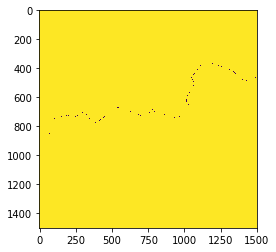

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1500, 'height': 1500, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 360744.0,
       0.0, -3.0, 9833412.0)}
[<shapely.geometry.linestring.LineString object at 0x121b23160>, <shapely.geometry.linestring.LineString object at 0x11e568978>]


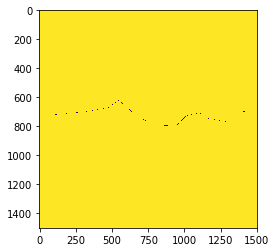

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1500, 'height': 1500, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 360744.0,
       0.0, -3.0, 9828912.0)}
[<shapely.geometry.linestring.LineString object at 0x12220d048>, <shapely.geometry.linestring.LineString object at 0x12220d908>, <shapely.geometry.linestring.LineString object at 0x12220db38>, <shapely.geometry.linestring.LineString object at 0x12220d550>]


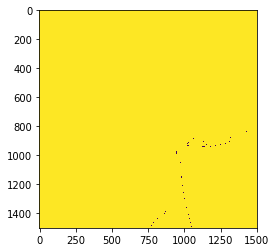

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1500, 'height': 916, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 360744.0,
       0.0, -3.0, 9824412.0)}
[<shapely.geometry.linestring.LineString object at 0x11e568978>, <shapely.geometry.linestring.LineString object at 0x11e568b70>, <shapely.geometry.linestring.LineString object at 0x11e568358>, <shapely.geometry.linestring.LineString object at 0x122302358>, <shapely.geometry.linestring.LineString object at 0x1214c5ba8>]


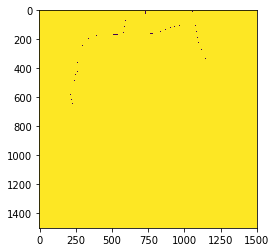

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1500, 'height': 1500, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 365244.0,
       0.0, -3.0, 9837912.0)}
[<shapely.geometry.linestring.LineString object at 0x12220d048>, <shapely.geometry.linestring.LineString object at 0x121b93898>, <shapely.geometry.linestring.LineString object at 0x12147b5f8>]


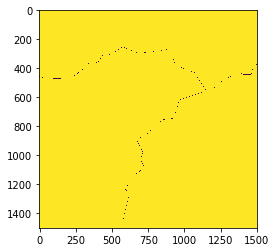

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1500, 'height': 1500, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 365244.0,
       0.0, -3.0, 9833412.0)}
[<shapely.geometry.linestring.LineString object at 0x11e39e550>, <shapely.geometry.linestring.LineString object at 0x11e39e668>, <shapely.geometry.linestring.LineString object at 0x1221dfdd8>]


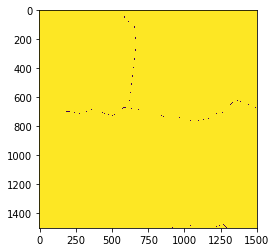

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1500, 'height': 1500, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 365244.0,
       0.0, -3.0, 9828912.0)}
[<shapely.geometry.linestring.LineString object at 0x11e39e668>, <shapely.geometry.linestring.LineString object at 0x11e39e860>, <shapely.geometry.linestring.LineString object at 0x121b25b00>, <shapely.geometry.linestring.LineString object at 0x121af5908>]


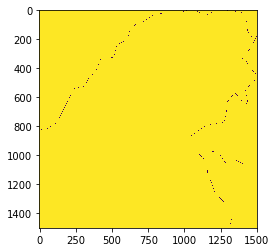

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1500, 'height': 916, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 365244.0,
       0.0, -3.0, 9824412.0)}
[<shapely.geometry.linestring.LineString object at 0x11ea6a9e8>, <shapely.geometry.linestring.LineString object at 0x1221dfdd8>, <shapely.geometry.linestring.LineString object at 0x1221df550>]


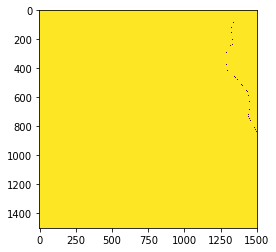

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1500, 'height': 1500, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 369744.0,
       0.0, -3.0, 9837912.0)}
[<shapely.geometry.linestring.LineString object at 0x1214e3470>, <shapely.geometry.linestring.LineString object at 0x1214e3eb8>, <shapely.geometry.linestring.LineString object at 0x1214e3390>, <shapely.geometry.linestring.LineString object at 0x12175f860>, <shapely.geometry.linestring.LineString object at 0x12175f0b8>, <shapely.geometry.linestring.LineString object at 0x12175f208>]


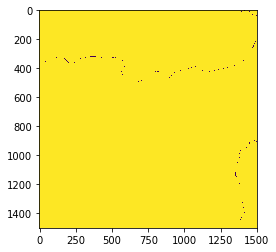

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1500, 'height': 1500, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 369744.0,
       0.0, -3.0, 9833412.0)}
[<shapely.geometry.linestring.LineString object at 0x1056c4940>, <shapely.geometry.linestring.LineString object at 0x1056c42e8>, <shapely.geometry.linestring.LineString object at 0x1056c4518>, <shapely.geometry.linestring.LineString object at 0x1056c4e48>, <shapely.geometry.linestring.LineString object at 0x12146ee48>, <shapely.geometry.linestring.LineString object at 0x12146eef0>, <shapely.geometry.linestring.LineString object at 0x12146e0b8>, <shapely.geometry.linestring.LineString object at 0x12146e550>]


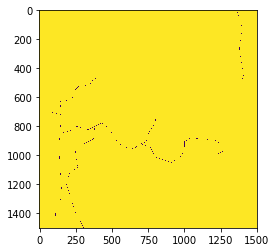

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1500, 'height': 1500, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 369744.0,
       0.0, -3.0, 9828912.0)}
[<shapely.geometry.linestring.LineString object at 0x1214e3cc0>, <shapely.geometry.linestring.LineString object at 0x1214e34a8>, <shapely.geometry.linestring.LineString object at 0x11e3d4898>, <shapely.geometry.linestring.LineString object at 0x1217c7d68>]


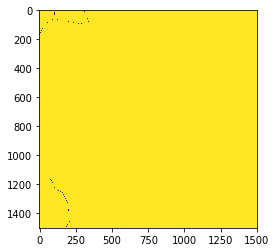

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1500, 'height': 916, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 369744.0,
       0.0, -3.0, 9824412.0)}
[<shapely.geometry.linestring.LineString object at 0x121f7be80>, <shapely.geometry.linestring.LineString object at 0x121f7bac8>, <shapely.geometry.linestring.LineString object at 0x121f7b9e8>, <shapely.geometry.linestring.LineString object at 0x121f7bda0>]


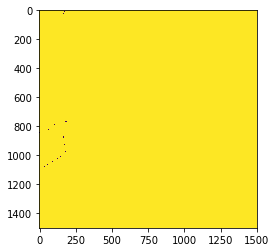

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 326, 'height': 1500, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 374244.0,
       0.0, -3.0, 9837912.0)}
[<shapely.geometry.linestring.LineString object at 0x120c18898>, <shapely.geometry.linestring.LineString object at 0x11e4bc160>, <shapely.geometry.linestring.LineString object at 0x1223045f8>, <shapely.geometry.linestring.LineString object at 0x1217c71d0>]


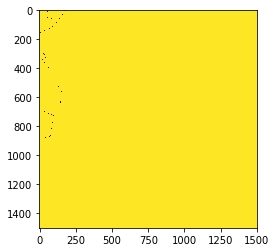

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 326, 'height': 1500, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 374244.0,
       0.0, -3.0, 9833412.0)}


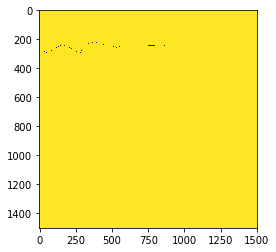

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 326, 'height': 1500, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 374244.0,
       0.0, -3.0, 9828912.0)}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 326, 'height': 916, 'count': 4, 'crs': CRS({'init': 'epsg:32750'}), 'transform': Affine(3.0, 0.0, 374244.0,
       0.0, -3.0, 9824412.0)}


In [1273]:
n = 0
idx=create_spatial_index()
for file in Path(RAW_IMAGES).iterdir():
    if file.name.endswith(('.tif', '.tiff')):
        make_tiles(file)
        n=n+1
        if n >= 1:
            break